# ** Translation program based on pyramidal Lucas Kanade. Points are selected and moved along with the motion. **

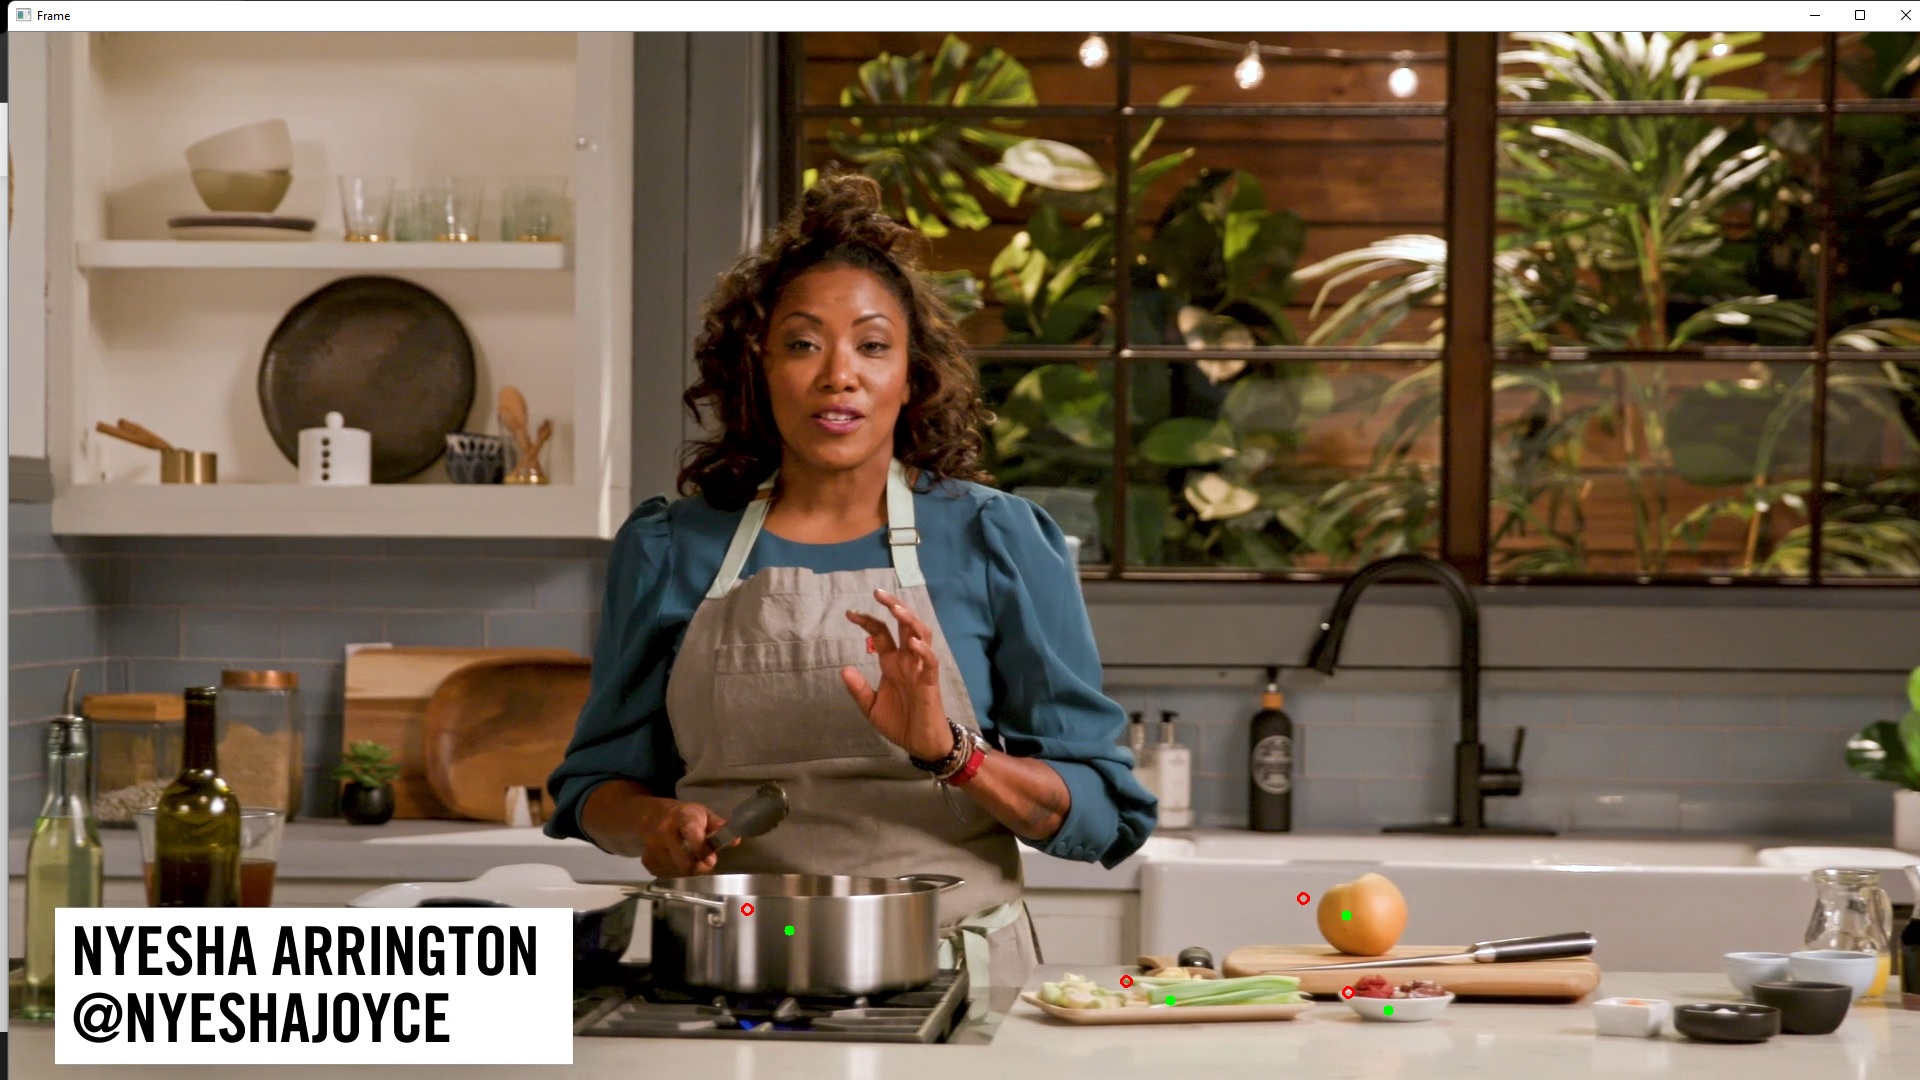

# Author: Aloukik Aditya (Computer Vision Engineer)
## Email: aloukikaditya@gmail.com
## Phone: +1 905 906 0188

# Step 1: importing all the required libraries

In [3]:
import os
import glob
import cv2
import time
import numpy as np
import pandas as pd
import sys

# Step 2: Enter user defined values

In [4]:

Total_points = 4
First_frame = 0 # selecting points at this frame

# Step 3: Importing image dataset 

In [5]:
cwd = os.getcwd()
directory = cwd + "\\frames"
cwd_len = len(directory) 
img_dir = directory # Enter Directory of all images 
data_path = os.path.join(img_dir, "*.png") 

img_files = glob.glob(data_path)
img_files = sorted(img_files, key=lambda name: int(name[cwd_len+1:-4]))

total_files = len(img_files)

# Step 4: Defining function for pyramidal Lucas Kanade (PLK)

In [18]:
# Parameters for PLK

#Syntax: cv2.calcOpticalFlowPyrLK(prevImg, nextImg, prevPts, nextPts[, winSize[, maxLevel[, criteria]]])

# Parameters:
# prevImg – first 8-bit input image
# nextImg – second input image
# prevPts – vector of 2D points for which the flow needs to be found.
# winSize – size of the search window at each pyramid level.
# maxLevel – 0-based maximal pyramid level number; if set to 0, pyramids are not used (single level), if set to 1, two levels are used, and so on.
# criteria – parameter, specifying the termination criteria of the iterative search algorithm.

# Return:
# nextPts – output vector of 2D points (with single-precision floating-point coordinates) containing the calculated new positions of input features in the second image; when OPTFLOW_USE_INITIAL_FLOW flag is passed, the vector must have the same size as in the input.
# status – output status vector (of unsigned chars); each element of the vector is set to 1 if the flow for the corresponding features has been found, otherwise, it is set to 0.
# err – output vector of errors; each element of the vector is set to an error for the corresponding feature, type of the error measure can be set in flags parameter; if the flow wasn’t found then the error is not defined (use the status parameter to find such cases).


lk_params = dict(winSize = (15, 15),
maxLevel = 4,
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# this function runs for each frame and each point
def optical_flow(frame, old_gray, gray_frame, point, new_points, old_points, status, error,x,y):
    
    #cv2.circle(frame, point, 5, (0, 0, 255), 2)
    new_points, status, error = cv2.calcOpticalFlowPyrLK(old_gray, gray_frame, old_points, None, **lk_params)
    old_gray = gray_frame.copy()
    old_points = new_points
    x, y = new_points.ravel()
#     old_x,_oldy = 
    #new
    cv2.circle(frame, (x, y), 5, (0, 0, 255), 2)
    cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
    
    
    
    return frame, old_gray, gray_frame, point, new_points, old_points, status, error, x, y

# Step 5: creating function for global variables and assigning their values

In [19]:
def create_var():
    
    global x,y,status,error, df_columns,frame_name, coordinate_list, pointt, gray_frame_list, old_gray_list,point_selected, old_points, point_selected_list , point_list,old_points_list, new_points_list, frame, gray_frame
    point_selected = False
    
    frame = cv2.imread(img_files[0])
    
    # variables and lists used in PLK optical_flow fucntions
    point_selected_list = []
    point_list = []
    old_points_list = []
    new_points_list = []
    old_gray_list = []
    gray_frame_list = []
    status = 0
    error = 0
    x = 0
    y = 0
    
    # variables and lists used for pandas dataframe, which helps in retrieving coordinate for each point
    coordinate_list = []
    df_columns = []
    frame_name = []
    

    # Assigning empty values to all variables and list (legnth of total points)
    for i in range(Total_points):
        
        point_selected_list.append(False)
        point_list.append(())
        old_points_list.append(np.array([[]]))
        new_points_list.append(np.array([[]]))
        old_gray_list.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        gray_frame_list.append(np.array([[]]))
        coordinate_list.append([])
        df_columns.append(("P"+str(i+1)))
        
    

# Step 6: Creating Mouse function - used for selecting initial coordinates

In [20]:

def select_point(event, x, y, flags, params):
    
    # Global variables specifically for mouse functionality
    global point, point_selected, old_points, point_selected_list , point_list, old_points_list
    
    # getting coordinates for all points
    for i in range(Total_points):
        if event == cv2.EVENT_LBUTTONDOWN:
            count_f = 0
            
            if point_selected_list[i] == True:
                count_f = 1
                continue
            
            point = (x, y)
            point_selected = True
            old_points = np.array([[x, y]], dtype=np.float32)
            
            point_selected_list[i] = point_selected
            point_list[i] = point
            old_points_list[i] = old_points
            if count_f == 0:
                break
            


In [21]:
# frame = cv2.imread(img_files[0])
# cv2.imshow("Frame", frame)
# cv2.waitKey()
# #cv2.destroyAllWindows()


# Step 7: Main code block

In [22]:
#creating all the global variables
create_var()

#setting up call back function (if mouse's left button is detected, it activates and calls select_point function)
cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", select_point)


counter = 0

#Loop for total_frames
for f1 in img_files:
    
    frame = cv2.imread(f1)

    #loop to gray image for each frame (this is a parameter, used in PLK optical_flow func)
    for gray in range(Total_points):
        gray_frame_list[gray] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
       
    
    # If left button is hit, this activates
    if point_selected is True:
        
        # If you select less points on the screen, this activates and stops the program
        if False in point_selected_list:
            print("Error! you did not select " + str(Total_points) +" points. Please try again!")
            cv2.destroyAllWindows()
            sys.exit("Error message")
            break

        # Main PLK optical_flow function with all the parameters, updated over each frame and point (retrieves the location for next point)
        for j in range(Total_points):
            frame, old_gray_list[j],gray_frame_list[j], point_list[j],new_points_list[j],old_points_list[j],status, error,x,y = optical_flow(frame, 
                                                                                                                                                     old_gray_list[j],
                                                                                                                                                     gray_frame_list[j], 
                                                                                                                                                     point_list[j],
                                                                                                                                                     new_points_list[j],
                                                                                                                                                     old_points_list[j],
                                                                                                                                                     status, 
                                                                                                                                                     error,
                                                                                                                                                     x,
                                                                                                                                                     y)
            # This list get the coordinates for each point and for each frame                                                                          
            coordinate_list[j].append((x,y))
            
            
    
    # retrieves the name of the frames and displays the frames
    if counter > First_frame:
        frame_name.append(f1[-8:])
        cv2.imshow("Frame", frame)
        
                                                                                                                                             
    # Writes the instruction for selecting points on the screen and trigger to select points on the screen                                                                                                                                                                                                                                                                               
    if counter == First_frame:
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, 'click ' + str(Total_points) + ' points and hit enter', (10,50), font, 2, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow("Frame", frame)
        cv2.waitKey()

    # Exits the loop if ESC key is pressed    
    k = cv2.waitKey(2) & 0xff 
    if k == 27:
        break
    counter += 1
    

#END and stop
cv2.destroyAllWindows()

In [26]:
coordinate_list

[[(817.23694, 886.87744),
  (813.276, 887.2832),
  (809.44867, 887.2752),
  (805.7138, 887.067),
  (803.2821, 886.3758),
  (803.28186, 886.36835),
  (802.4484, 885.64386),
  (802.16406, 884.7342),
  (801.8822, 883.45056),
  (801.3674, 881.9161),
  (801.4405, 882.9387),
  (801.35455, 882.0183),
  (801.63434, 882.4025),
  (802.7274, 882.934),
  (803.7602, 882.7972),
  (803.76025, 882.8016),
  (805.2354, 882.9255),
  (806.667, 882.9713),
  (808.95667, 883.4326),
  (812.256, 884.85675),
  (812.25604, 884.8583),
  (815.4756, 887.37946),
  (817.9814, 889.3977),
  (819.1596, 886.9227),
  (819.67224, 888.3672),
  (819.51935, 888.44714),
  (819.6379, 891.07355),
  (819.3797, 894.0689),
  (819.0532, 897.2627),
  (818.29913, 898.7379),
  (818.2994, 898.7348),
  (817.1358, 900.1715),
  (815.94324, 900.4483),
  (814.5815, 900.10144),
  (812.6514, 900.0192),
  (812.6649, 900.1149),
  (810.6801, 899.25433),
  (809.06116, 898.15814),
  (807.49786, 896.6721),
  (806.20874, 895.29865),
  (806.2243, 895.

In [14]:
cv2.destroyAllWindows()

# Step 8: Creating Dataframe and saving (x,y) coordinates in it

In [19]:
# converting list of x,y coordinates to pandas dataframe
df = pd.DataFrame(coordinate_list)
df = df.transpose()

# Assigining column name
df.columns = df_columns

In [16]:
# Seperates the (x,y) to seperate x and y column for each point
for i in range(1,Total_points+1):
    df[[str("p" + str(i) + "_x"), str("p" + str(i) + "_y")]] = pd.DataFrame(df[str('P' + str(i))].tolist(), index=df.index)
    df = df.drop([str('P' + str(i))], axis=1)
# inserting frame_name at first column
df.insert(0, "Frame_name",frame_name, True)

# Step 9: Display the Dataframe

In [17]:
#display the dataframe
df

,Frame_name,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
0,0002.png,716.999878,892.000488,1111.001099,942.999817,1317.999756,861.998962,1363.000000,948.000122
1,0003.png,712.269714,892.494751,1107.145996,943.158813,1313.963135,861.959900,1359.147339,947.997864
2,0004.png,708.928650,892.336731,1103.371704,943.001831,1310.306152,861.814575,1355.277344,947.963623
3,0005.png,705.209778,892.662476,1099.823120,942.691833,1306.654297,861.762329,1351.724609,947.686768
4,0006.png,702.187561,892.149963,1097.489136,942.275085,1304.389648,861.567322,1349.342529,947.187012
...,...,...,...,...,...,...,...,...,...
181,0183.png,902.325256,936.262451,1299.700317,983.080139,1507.660522,900.310547,1554.226074,988.419617
182,0184.png,903.118530,936.682678,1300.621216,984.098328,1508.579834,901.420532,1555.328613,989.453735
183,0185.png,904.556946,936.355408,1302.030151,983.296509,1510.069336,900.931885,1556.810547,988.562500
184,0186.png,905.332642,935.131592,1303.180176,980.815186,1511.232178,898.609436,1557.819458,986.111328


# Step 10: Converting and saving Dataframe to CSV format

In [18]:
#Converting and saving pandas dataframe to csv
df.to_csv('Translation_coordinates.csv', index=False)

In [14]:
# display all the installed libraries for the environment
!pip list

Package               Version
--------------------- ---------
argon2-cffi           21.1.0
async-generator       1.10
attrs                 21.2.0
backcall              0.2.0
bleach                4.1.0
certifi               2020.12.5
cffi                  1.15.0
colorama              0.4.4
decorator             5.1.0
defusedxml            0.7.1
entrypoints           0.3
importlib-metadata    4.8.2
ipykernel             5.5.6
ipython               7.16.1
ipython-genutils      0.2.0
jedi                  0.18.0
Jinja2                3.0.3
jsonschema            3.2.0
jupyter-client        7.0.6
jupyter-core          4.9.1
jupyterlab-pygments   0.1.2
MarkupSafe            2.0.1
mistune               0.8.4
nbclient              0.5.5
nbconvert             6.0.7
nbformat              5.1.3
nest-asyncio          1.5.1
notebook              6.4.5
numpy                 1.19.5
opencv-contrib-python 4.5.4.58
opencv-python         3.4.0.14
packaging             21.2
pandas                1.1.5
pa

# Final step: retrieving all the installed libraries and saving it to requirements.txt file

In [15]:
# creates requirements.txt file
!pip freeze > requirements.txt  # Python3